## Install packages

In [1]:
    %%bash 
home=`pwd`
. $home/env
pip3 install mysql-connector-python

bash: line 2: /home/ec2-user/SageMaker/amazon-aurora-call-to-amazon-sagemaker-sample/stk-sample/env-build/sagemaker/env: No such file or directory
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [500]:
import sagemaker
execution_role = sagemaker.get_execution_role()
print(execution_role)

arn:aws:iam::163538056407:role/service-role/AmazonSageMaker-ExecutionRole-20200913T212219


## Get train and test data from Aurora DB

In [2]:
%%time

import json
import boto3
import csv
import mysql.connector
import sys
import os
import configparser

config = configparser.ConfigParser()

config.read('rds.ini')

ENDPOINT=config['default']['ENDPOINT']
USR=config['default']['USR']
PASWD=config['default']['PASWD']
REGION=config['default']['REGION']
DBNAME=config['default']['DBNAME']

client = boto3.client('rds')

CPU times: user 178 ms, sys: 24.9 ms, total: 203 ms
Wall time: 1.21 s


Getting the right size of the grouping

In [475]:
%%time
import pandas as pd

group_size=100

try:
  conn =  mysql.connector.connect(host=ENDPOINT, user=USR, passwd=PASWD, port=3306, database=DBNAME)
  cur = conn.cursor()
  cur.execute("""SELECT count(id) from actions where class is not null""")
  actions_size_list=cur.fetchall()
  actions_size_df=pd.DataFrame(actions_size_list)
  actions_size=actions_size_df[0].values[0]
  print("actions_size="+str(actions_size))
  modulo_size=actions_size/group_size
  print("modulo_size="+str(modulo_size))
except Exception as e:
  print("Database connection failed due to {}".format(e))

actions_size=32290
modulo_size=322.9
CPU times: user 16.5 ms, sys: 4.11 ms, total: 20.6 ms
Wall time: 93.9 ms


In [476]:
%%time
import pandas as pd

#SELECT FLOOR(id/25) sessionid,id,m_ticks,m_kart_id,m_action,m_value,m_value_l,m_value_r,class

modulo_size=224

try:
  conn =  mysql.connector.connect(host=ENDPOINT, user=USR, passwd=PASWD, port=3306, database=DBNAME)
  cur = conn.cursor()
  
  cur.execute("""SELECT id,m_ticks,m_action,m_value,m_value_l,m_value_r,class FROM actions WHERE class=0 order by id""")
  bot_action_list=cur.fetchall()
  cur.execute("""SELECT id,m_ticks,m_action,m_value,m_value_l,m_value_r,class FROM actions WHERE class=1 order by id""")
  player_action_list=cur.fetchall()  
  cur.execute("""
                  SELECT FLOOR(id/100) sessionid,id,m_ticks,m_kart_id,m_action,m_value,m_value_l,m_value_r,class
                  FROM actions 
                  WHERE class IS NOT NULL
                  ORDER BY id,m_kart_id 
              """)
  action_list=cur.fetchall()  
except Exception as e:
  print("Database connection failed due to {}".format(e))
  

CPU times: user 115 ms, sys: 13.3 ms, total: 128 ms
Wall time: 221 ms


## Prepare the game players actions 

In [477]:
actions = pd.DataFrame(action_list)
actions.rename(columns={0:'sessionid',
                        1:'id',
                        2:'m_ticks',
                        3:'m_kart_id',
                        4:'m_action',
                        5:'m_value',
                        6:'m_value_l',
                        7:'m_value_r',
                        8:'class'
                     }, 
                 inplace=True)
print(actions.columns)
print(actions.count())

Index(['sessionid', 'id', 'm_ticks', 'm_kart_id', 'm_action', 'm_value',
       'm_value_l', 'm_value_r', 'class'],
      dtype='object')
sessionid    32290
id           32290
m_ticks      32290
m_kart_id    32290
m_action     32290
m_value      32290
m_value_l    32290
m_value_r    32290
class        32290
dtype: int64


We used `id` for sorting the session actions but now we dont need it anymore.

In [478]:
min_actions=actions.drop('id',axis=1)

Checking the amount of data we lose in aggreagtion. The session length is 25 so we are going loose all the session that are smaller than 25

In [480]:
min_actions.describe()

min_actions.head(27)
print(min_actions.groupby(['sessionid'],axis=0).size())
sum=0
for i in min_actions.groupby(['sessionid'],axis=0).size():
  #print(i,end='####')
  if(i>25):
    sum=sum+i
print(sum)
min_actions.count()

sessionid
0       26
1       29
2       25
3       28
4       27
      ... 
470    100
471    100
472    100
473    100
474     14
Length: 345, dtype: int64
32101


sessionid    32290
m_ticks      32290
m_kart_id    32290
m_action     32290
m_value      32290
m_value_l    32290
m_value_r    32290
class        32290
dtype: int64

Checking the size of sessions. Session is an ordered set of actions grouped by the sessiondid, the player kart id and the classification. 

Classification is set as 1 in case of human, and 0 as bot.

The `sum` is the number of remaining data after aggregating on both the kartid and class.

In [352]:
print(min_actions.groupby(['sessionid','m_kart_id','class'],axis=0).size())
print(min_actions.groupby(['class'],axis=0).size())
sum=0
for i in min_actions.groupby(['sessionid','m_kart_id','class'],axis=0).size():
    #print(i,end='###')
    if (i>=25):
      sum=sum+i
print(sum)

sessionid  m_kart_id  class
0          0.0        1         13
           1.0        1         13
1          0.0        1         14
           1.0        1         15
2          0.0        1         14
                              ... 
452        1.0        1         74
453        0.0        3         60
           1.0        1         40
454        0.0        3        100
455        0.0        3         28
Length: 620, dtype: int64
class
0     3817
1    26399
3      188
dtype: int64
29617


Construct a dictonary based on `sessionid` and action classification `class`

In [482]:
player_session_dict = {}
i=0

for index, row in min_actions.iterrows():
  i=i+1
  play_action_val=row['m_ticks'],row['m_action'],row['m_value'],row['m_value_l'],row['m_value_r']
  play_action_key=row['sessionid'],row['m_kart_id'],row['class']
  if(player_session_dict.get(play_action_key)):
    session_list=player_session_dict[play_action_key]
    session_list.append(play_action_val)
    player_session_dict[play_action_key]=session_list 
  else:
    session_list=[]
    session_list.append(play_action_val)
    player_session_dict[play_action_key]=session_list
print(i)

32290


Check the session length (number of actions in a session)

In [ ]:
sum=0
for key in player_session_dict.keys():
  if (len(player_session_dict[key])>=25):
    print(len(player_session_dict[key]),end = '###')
    sum=sum+len(player_session_dict[key])
print()
print(i)
print(sum)
len(player_session_dict)

Transpose the dataframe to a new column strucutre that concatenates series of consecutive actions in a fixed size of 25

In [484]:
len(player_session_dict)

653

In [487]:
import numpy as np
session_len=25
#a line in the array is five set of actions plus the classification 
size_of_arr_line=session_len*5+1
sessions_array = np.zeros((1003,size_of_arr_line), dtype=float, order='C')

i=0
sum_of_actions=0
for key in player_session_dict:
  raw_session=player_session_dict[key]
  #break the session into equal parts 25 actions long
  sessions_list=[raw_session[i:i + session_len] for i in range(0, len(raw_session), session_len)]  
  #every session has 25 action set
  for session in sessions_list:
    #including only the full sessions with excatly 25 actions
    if(len(session)==session_len):
      new_row=[]
      for action in session:
        new_row.append(action[0])
        new_row.append(action[1])
        new_row.append(action[2])
        new_row.append(action[3])
        new_row.append(action[4])
      #add class field to the last column 
      new_row.append(key[2])
      sessions_array[i]=np.asarray(new_row)
      i=i+1 
print(i)

1003


In [489]:
df=pd.DataFrame(sessions_array) 

In [490]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
0,9114.0,1.0,3159.0,2218.0,-3296.0,9145.0,0.0,32768.0,2218.0,-3159.0,...,0.0,0.0,32768.0,0.0,1385.0,2.0,32768.0,0.0,0.0,1.0
1,1443.0,1.0,32768.0,0.0,0.0,1521.0,1.0,0.0,0.0,-32768.0,...,0.0,0.0,32768.0,0.0,3047.0,2.0,0.0,0.0,0.0,1.0
2,3967.0,0.0,32768.0,0.0,0.0,4082.0,2.0,32768.0,32768.0,0.0,...,0.0,32768.0,0.0,0.0,5361.0,0.0,0.0,32768.0,0.0,1.0
3,5420.0,1.0,32768.0,0.0,0.0,5480.0,1.0,0.0,0.0,-32768.0,...,1.0,0.0,0.0,-32768.0,7166.0,0.0,32768.0,0.0,0.0,1.0
4,7963.0,1.0,32768.0,32768.0,0.0,7964.0,0.0,0.0,32768.0,-32768.0,...,1.0,32768.0,0.0,0.0,9307.0,1.0,0.0,0.0,-32768.0,1.0


In [491]:
print(df.groupby(125,axis=0).size())
df.head(1)

125
0.0    120
1.0    883
dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
0,9114.0,1.0,3159.0,2218.0,-3296.0,9145.0,0.0,32768.0,2218.0,-3159.0,...,0.0,0.0,32768.0,0.0,1385.0,2.0,32768.0,0.0,0.0,1.0


To check if we did not loose data we need to multiple the number by 25

In [492]:
min_actions.groupby(['class'],axis=0).size()

class
0     3817
1    28473
dtype: int64

Check how much data was lost during transformation.

In [493]:
print(120/3817)
print(883/28473)

0.03143830233167409
0.031011835774242266


In [494]:
print(df.columns)
feature_columns = df.columns[:-1]
label_column = df.columns[-1]

print('feature_columns={}'.format(feature_columns))
print('label_column={}'.format(label_column))

features = df[feature_columns].values.astype('float32')
labels = (df[label_column].values).astype('float32')

RangeIndex(start=0, stop=126, step=1)
feature_columns=RangeIndex(start=0, stop=125, step=1)
label_column=125


### Prepare Data and Upload to S3

In [502]:
import io
import sagemaker.amazon.common as smac

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, features, labels)
buf.seek(0);

Now we upload the data to S3 using boto3.

In [503]:
import boto3
import os
import sagemaker

session = sagemaker.Session()
bucket = 'stk-events'

prefix = 'anticheat-model'
key = 'recordio-pb-data'

boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)

s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('Uploaded training data location: {}'.format(s3_train_data))

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Uploaded training data location: s3://stk-events/anticheat-model/train/recordio-pb-data
Training artifacts will be uploaded to: s3://stk-events/anticheat-model/output


In [504]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'linear-learner')

from sagemaker import get_execution_role

linear = sagemaker.estimator.Estimator(container,
                                       get_execution_role(), 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=session)
linear.set_hyperparameters(feature_dim=features.shape[1],
                           predictor_type='binary_classifier',
                           mini_batch_size=200)

linear.fit({'train': s3_train_data},wait=False)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


# IGNORE THE BELOW

Populate `actions_dict` with game sessions that are even set of player actions i.e.
```
sessionid --> {
    {ticks,action,value,value_l,value_r,class},
    {ticks,action,value,value_l,value_r,class},
    ....
    {ticks,action,value,value_l,value_r,class}
}
```

In [33]:
actions_dict = {}

for x in actions.values:
  _grp=x[0]
  _id=x[1]
  _m_ticks=x[2]
  _m_kart_id=x[3]
  _m_action=x[4]
  _m_value=x[5]
  _m_value_l=x[6]
  _m_value_r=x[7]
  _class=x[8]
  action = _m_ticks,_m_action,_m_value,_m_value_l,_m_value_r,_class
  if(actions_dict.get(_grp)):
    session_list.append(action)
    actions_dict[_grp]=session_list
  else:
    session_list=[]
    session_list.append(action)
    actions_dict[_grp]=session_list

In [ ]:
actions_dict[198]

checking the size of each session i.e., the number of game event tuples in a session

In [472]:
print('sessionid -> size_of_session ### ') 
for key in actions_dict:
  print(key, '->', len(actions_dict[key]), end = ' ### ')

sessionid -> size_of_session ### 
5.0 -> 155 ### 6.0 -> 155 ### 0.0 -> 155 ### 7.0 -> 155 ### 14.0 -> 155 ### 1.0 -> 155 ### 8.0 -> 155 ### 15.0 -> 155 ### 2.0 -> 155 ### 9.0 -> 155 ### 17.0 -> 155 ### 12.0 -> 155 ### 16.0 -> 155 ### 4.0 -> 155 ### 19.0 -> 155 ### 3.0 -> 155 ### 11.0 -> 155 ### 18.0 -> 155 ### 13.0 -> 155 ### 10.0 -> 155 ### 

Since we have fixed size of actions in a session, we convert the actions dictionary to a two dimensions array of `len(actions_dict)` and `actions_dict[key]`

In [ ]:
session_length=155
action_dim=6
actions_array = np.zeros((len(actions_dict),session_length,action_dim), dtype=float, order='C')
for key in actions_dict:
    session_arr=np.array(actions_dict[key])
    actions_array[int(key)]=session_arr

#for i in actions_array[1]:
#    print(i[0],i[1],i[2],i[3],i[4],i[5])
actions_array[1]    
#actions_array.reshape(-1,5)


In [ ]:
from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=50)

# automatically upload the training data to S3 and run the training job

rcf.fit(rcf.record_set(actions_array.reshape(-1,5)))
job_name = rcf.latest_training_job.job_name
print("Training job: %s" % job_name)

In [ ]:
for key in actions_dict:
    print(key, '->')
    print('(im_ticks,m_action,m_value,m_value_l,m_value_r,class)')
    for action in actions_dict[key]:
        print(action)

array([ 6.0000e+00,  6.0000e+00,  3.1000e+01,  0.0000e+00,  2.0000e+00,
        3.2768e+04,  0.0000e+00, -4.4790e+03,  1.0000e+00])

## Training - Linear Regression 

In [ ]:
import io
import sagemaker.amazon.common as smac

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, features, labels)
buf.seek(0);

## Convert the data to Dataframes

In [105]:
import pandas as pd
bot_actions = pd.DataFrame(bot_action_list)
player_actions = pd.DataFrame(player_action_list)
actions = pd.DataFrame(action_list)

In [4]:
bot_actions.rename(columns={0:'id',
                            1:'m_ticks',
                            2:'m_action',
                            3:'m_value',
                            4:'m_value_l',
                            5:'m_value_r',
                            6:'class'
                           }, 
                 inplace=True)

In [5]:
player_actions.rename(columns={0:'id',
                            1:'m_ticks',
                            2:'m_action',
                            3:'m_value',
                            4:'m_value_l',
                            5:'m_value_r',
                            6:'class'
                           }, 
                 inplace=True)

In [107]:
actions.rename(columns={0:'grp',
                        1:'id',
                        2:'m_ticks',
                        3:'m_action',
                        4:'m_value',
                        5:'m_value_l',
                        6:'m_value_r',
                        7:'class'
                     }, 
                 inplace=True)

In [318]:
bot_actions.columns

RangeIndex(start=0, stop=7, step=1)

In [321]:
player_actions.columns

RangeIndex(start=0, stop=7, step=1)

In [108]:
actions.columns

Index(['grp', 'id', 'm_ticks', 'm_action', 'm_value', 'm_value_l', 'm_value_r',
       'class'],
      dtype='object')

In [112]:
actions.head(4)

,grp,id,m_ticks,m_action,m_value,m_value_l,m_value_r,class
0,5,5,31.0,1.0,4479.0,0.0,0.0,1
1,6,6,31.0,2.0,32768.0,0.0,-4479.0,1
2,7,7,31.0,1.0,2943.0,0.0,0.0,1
3,8,8,31.0,2.0,32768.0,0.0,-2943.0,1


In [ ]:
actions.describe()

## Let's look for interesting data patterns

In [169]:
import matplotlib.pyplot as plt
import pandas as pd

### Corralation between ticks in bots and humans

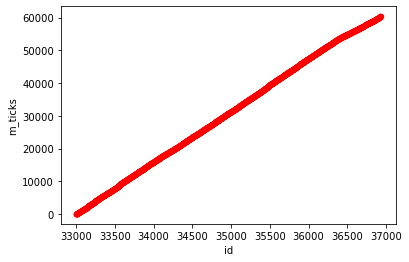

In [170]:
bot_actions.plot(kind='scatter',x='id',y='m_ticks',color='red')
plt.show()

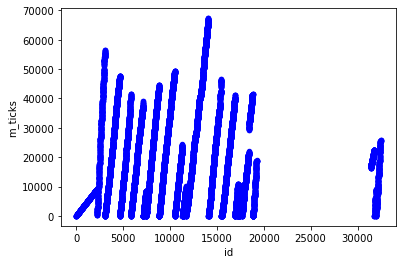

In [171]:
player_actions.plot(kind='scatter',x='id',y='m_ticks',color='blue')
plt.show()

We can see that `m_ticks` are random for humans and consistent for bots. 

### Correlation between action values in bots and humans

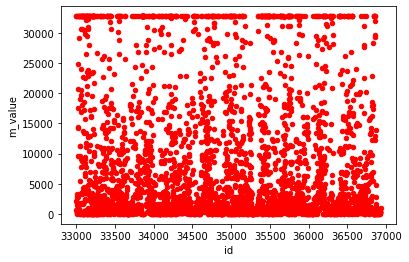

In [172]:
bot_actions.plot(kind='scatter',x='id',y='m_value',color='red')
plt.show()

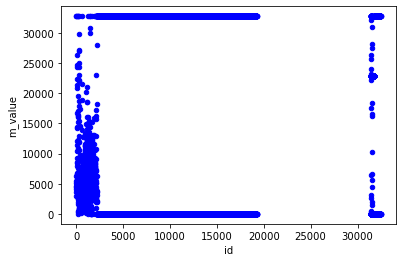

In [173]:
player_actions.plot(kind='scatter',x='id',y='m_value',color='blue')
plt.show()

We can see that bots perform more granular actions `m_value` as oppose to humans `m_value`s that tend to be sharper.

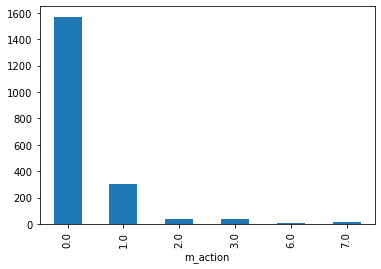

In [186]:
#bot_actions[100:110].plot(kind='bar',x='m_action',y='id')
bot_actions.groupby('m_action')['m_value_l'].nunique().plot(kind='bar')
plt.show()

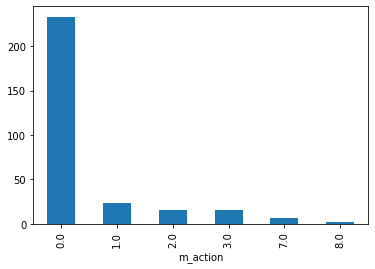

In [185]:
player_actions.groupby('m_action')['m_value_l'].nunique().plot(kind='bar')
plt.show()

## Prepare the data for RCF

Going to aggregate game actions in `n` size chucks as game-action patterns for training so inference calls will be set of game actions by player to learn if the set represents a cheater of a human.

In [75]:
import pandas as pd

group_size = 10  

numbers = list(range(len(actions.index) // group_size)) * group_size
numbers.sort()
numbers = pd.Series(numbers)
actions = pd.concat([actions, numbers], ignore_index=True, axis=1)
actions.columns = ['id', 'm_ticks', 'm_action', 'm_value', 'm_value_l', 'm_value_r',
       'class', 'group_number']

grouped_actions = actions.groupby('group_number').filter(lambda x: len(x) == group_size)


In [76]:
grouped_actions.describe()

,id,m_ticks,m_action,m_value,m_value_l,m_value_r,class,group_number
count,22460.000000,22460.000000,22460.000000,22460.000000,22460.000000,22460.000000,22460.000000,22460.000000
mean,15594.184283,21819.256723,1.164381,14664.396572,7860.576714,-7794.692965,0.830321,1122.500000
std,10854.477746,15954.322683,1.767197,15684.167394,13376.042848,13482.819427,0.375359,648.378722
min,5.000000,0.000000,0.000000,0.000000,0.000000,-32768.000000,0.000000,0.000000
25%,7266.750000,7775.000000,0.000000,0.000000,0.000000,-7102.000000,1.000000,561.000000
50%,12881.500000,19345.000000,1.000000,3044.000000,0.000000,0.000000,1.000000,1122.500000
75%,18496.250000,33684.500000,1.000000,32768.000000,8694.000000,0.000000,1.000000,1684.000000
max,36922.000000,67293.000000,8.000000,32768.000000,32768.000000,0.000000,1.000000,2245.000000


In [63]:
grouped_actions.values

array([[ 5.0000e+00,  3.1000e+01,  1.0000e+00, ...,  0.0000e+00,
         1.0000e+00,  0.0000e+00],
       [ 6.0000e+00,  3.1000e+01,  2.0000e+00, ..., -4.4790e+03,
         1.0000e+00,  0.0000e+00],
       [ 7.0000e+00,  3.1000e+01,  1.0000e+00, ...,  0.0000e+00,
         1.0000e+00,  0.0000e+00],
       ...,
       [ 3.6920e+04,  6.0171e+04,  1.0000e+00, ..., -2.1900e+02,
         0.0000e+00,  2.2450e+03],
       [ 3.6921e+04,  6.0202e+04,  1.0000e+00, ..., -2.5200e+02,
         0.0000e+00,  2.2450e+03],
       [ 3.6922e+04,  6.0233e+04,  1.0000e+00, ..., -2.9100e+02,
         0.0000e+00,  2.2450e+03]])

In [23]:
grouped_actions.values

array([[ 5.0000e+00,  3.1000e+01,  1.0000e+00, ...,  0.0000e+00,
         1.0000e+00,  0.0000e+00],
       [ 6.0000e+00,  3.1000e+01,  2.0000e+00, ..., -4.4790e+03,
         1.0000e+00,  0.0000e+00],
       [ 7.0000e+00,  3.1000e+01,  1.0000e+00, ...,  0.0000e+00,
         1.0000e+00,  0.0000e+00],
       ...,
       [ 3.6920e+04,  6.0171e+04,  1.0000e+00, ..., -2.1900e+02,
         0.0000e+00,  2.2450e+03],
       [ 3.6921e+04,  6.0202e+04,  1.0000e+00, ..., -2.5200e+02,
         0.0000e+00,  2.2450e+03],
       [ 3.6922e+04,  6.0233e+04,  1.0000e+00, ..., -2.9100e+02,
         0.0000e+00,  2.2450e+03]])

In [25]:
grouped_actions

,id,m_ticks,m_action,m_value,m_value_l,m_value_r,class,group_number
0,5,31.0,1.0,4479.0,0.0,0.0,1,0.0
1,6,31.0,2.0,32768.0,0.0,-4479.0,1,0.0
2,7,31.0,1.0,2943.0,0.0,0.0,1,0.0
3,8,31.0,2.0,32768.0,0.0,-2943.0,1,0.0
4,20,62.0,1.0,5423.0,0.0,-4479.0,1,0.0
...,...,...,...,...,...,...,...,...
22455,36916,60109.0,0.0,48.0,74.0,-158.0,0,2245.0
22456,36918,60140.0,1.0,219.0,48.0,-158.0,0,2245.0
22457,36920,60171.0,1.0,252.0,48.0,-219.0,0,2245.0
22458,36921,60202.0,1.0,291.0,48.0,-252.0,0,2245.0


In [ ]:
grouped_actions.iloc[:,-1:].values.tolist()

In [47]:
grouped_actions.iloc[:,:-1].values

array([[ 5.0000e+00,  3.1000e+01,  1.0000e+00, ...,  0.0000e+00,
         0.0000e+00,  1.0000e+00],
       [ 6.0000e+00,  3.1000e+01,  2.0000e+00, ...,  0.0000e+00,
        -4.4790e+03,  1.0000e+00],
       [ 7.0000e+00,  3.1000e+01,  1.0000e+00, ...,  0.0000e+00,
         0.0000e+00,  1.0000e+00],
       ...,
       [ 3.6920e+04,  6.0171e+04,  1.0000e+00, ...,  4.8000e+01,
        -2.1900e+02,  0.0000e+00],
       [ 3.6921e+04,  6.0202e+04,  1.0000e+00, ...,  4.8000e+01,
        -2.5200e+02,  0.0000e+00],
       [ 3.6922e+04,  6.0233e+04,  1.0000e+00, ...,  4.8000e+01,
        -2.9100e+02,  0.0000e+00]])

## NO NEED FOR NOW - Encode categorical data - not sure if I need to do it as m_action is already a number

`m_action` is categorical data so we need to onehot encode it

In [116]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(bot_actions.m_action.values.reshape(-1, 1))
enc.categories_
bot_m_action_array=enc.transform(bot_actions.m_action.values.reshape(-1, 1)).toarray()

In [117]:
bot_m_action_array

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [118]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(player_actions.m_action.values.reshape(-1, 1))
enc.categories_
player_m_action_array=enc.transform(player_actions.m_action.values.reshape(-1, 1)).toarray()

In [119]:
player_m_action_array

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])